In [1]:
import torch as th
from torch import nn
import wandb

import numpy as np
import matplotlib.pyplot as plt

import librosa
import scipy.io.wavfile as wav

import tempfile
# Por reproducibilidad
th.manual_seed(42)
np.random.seed(42)

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# audio
import librosa
import librosa.display
import IPython as ip

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# redes audio
import torchaudio
import torchaudio.transforms as T
# redes visión
# import torchvision.models as tvm

# redes neuronales
from torch.utils.data import DataLoader
# from torchaudio.datasets import SPEECHCOMMANDS
# inspección de arquitectura
# from torchinfo import summary

# barras de progreso
from tqdm.auto import trange

#Counter
import collections

# Files
from os.path import join


In [3]:
import torchaudio.transforms as T
import torch.nn.functional as F

In [4]:
from moviepy.editor import *

In [5]:
# tomar n elementos de una secuencia
from itertools import islice as take
import os

In [6]:
import pandas as pd

# Lee el archivo de texto utilizando pd.read_csv()
df = pd.read_csv("./data/test_data_all_completo_3Ages.csv")


In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
def eval_epoch(dl, model, device, num_batches=None, task1=0, task2=1):
    """Evalua una época"""

    # Modelo en modo de evaluación
    # Congelar las estadísticas σ y μ
    model.eval()

    # evitamos que se registren las operaciones
    # en la gráfica de cómputo
    with th.no_grad():

        losses, accs_edad, accs_gen, f1s = [], [], [],[]
        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for batch in take(dl, num_batches):
            Xlote = batch[0].to(device)
            edad = batch[1].to(device)
            genero = batch[2].to(device)
            edad_num = batch[3].to(device)

            # print(edad_num)

            w_genero = 1.0
            w_edad = 1.0
            w_reg = 1.0

            if task1==0 and task2==1:
                y_hat_edades, y_hat_genero = model(Xlote)
                y_hat_genero = y_hat_genero.squeeze().float()

                y_hat_edades = y_hat_edades.to(device)

                # computamos las probabilidades
                y_prob = F.softmax(y_hat_edades, 1)
                # obtenemos la clase predicha
                y_pred = th.argmax(y_prob, 1)

                weightedf1= f1_score(edad, y_pred.cpu().numpy(), average='weighted')

                # print(y_hat_edades)
                # print(y_pred)
                # print(edad)

                # y_tensor = torch.tensor(y_hat_edades, dtype=torch.float, device=device)

                perdida_genero = F.binary_cross_entropy(y_hat_genero, genero.float()) #fp_edades

                # print(perdida_genero)


                perdida_edad = F.cross_entropy(y_hat_edades, edad.long()) #fp_genero

                # Calcular la pérdida total como la suma ponderada de las pérdidas individuales
                perdida_total = w_genero * perdida_genero.float() + w_edad * perdida_edad.float()

                metrica_genero_val = accuracy_score(genero,y_hat_genero.round())
                metrica_edad_val = accuracy_score(edad, y_pred )

                plt.figure(figsize=(8, 6))
                matriz_con= confusion_matrix(edad, y_pred)
                sns.heatmap(matriz_con,annot=True, cmap="Blues", fmt="d", cbar=False)

                plt.xlabel('Etiquetas Predichas')
                plt.ylabel('Etiquetas Verdaderas')
                plt.title('Matriz de Confusión')

                # Mostrar el mapa de calor
                plt.show()

                

                # computamos la pérdida
                loss = perdida_total

                # guardamos históricos
                losses.append(loss.item())
               
                accs_edad.append(metrica_edad_val.item())
                accs_gen.append(metrica_genero_val.item())

                f1s.append(weightedf1.item())

        loss = np.mean(losses)
        acc_gen = np.mean(accs_gen)
        acc_edad = np.mean(accs_edad)
        f1= np.mean(f1s)


        return loss, acc_gen, acc_edad, f1
        # return loss, acc, f1

In [10]:
# from ModelsLoss import QuartzNet_Cross1, QuartzNet_Cross2, LSTMDvector, Xvector
from Models_Soft2 import QuartzNet_Cross1, QuartzNet_Cross2, LSTMDvector, Xvector

torchvision is not available - cannot save figures


In [11]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [12]:
def identity(x):
    return x

In [13]:
#-------------------------------------- TIMIT ------------------------------
class TIMIT(Dataset):

    def __init__(self, df, waveform_tsfm=identity, label_tsfm=identity, cut=False, cut_sec=1, task1=0, task2=1):
        self.waveform_tsfm = waveform_tsfm
        self.label_tsfm = label_tsfm
        self.df = df
        self.cut = cut
        self.cut_sec = cut_sec

        self.task1 = task1
        self.task2 = task2

    def __getitem__(self, i):
        # print(i)
        dato = self.df.iloc[i]
        path = dato['path_from_data_dir']
        edad = dato['age_group']
        edad_num = dato['age']
        genero = dato['gender']

        directorio_actual = os.getcwd()
        directorio_actual +='/temp'

        audio = AudioFileClip(path)
        duracion = audio.duration

        if duracion >= self.cut_sec and self.cut:
            # CORTAR EL AUDIO
            # if self.cut:
            start_time = 0  # Tiempo de inicio en segundos

            # Realizar el corte
            cut_audio = audio.subclip(start_time)
            
            # Ajustar la duración del audio al valor deseado
            dur_audio = cut_audio.set_duration(self.cut_sec)
            
            with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_file:
                temp_path = temp_file.name

                # Exportar el audio cortado al archivo temporal
                dur_audio.write_audiofile(temp_path,verbose=False, logger=None)

            waveform, sample_rate = librosa.load(temp_path, sr=16000)
            os.remove(temp_path)
        else:
            waveform, sample_rate = librosa.load(path, sr = 16000)

        x = self.waveform_tsfm(waveform)


        # if self.task1 == 0 and self.task2==1:
        #     return x, genero, edad
        # elif self.task1 == 0 and self.task2 == 2:
        #     return x, genero, edad_num
        # else:
        return x, edad , genero , edad_num
    
    def __len__(self):
        return (len(self.df))
    

In [14]:
SAMPLE_RATE=16000

In [15]:
class WaveformPadTruncate(nn.Module):

    def __init__(self, secs=1, sample_rate=SAMPLE_RATE, transform_type=0):
        super().__init__()
        self.samples = secs * sample_rate
        self.transform_type=transform_type
        self.sample_rate=sample_rate

    def forward(self, waveform_librosa):
        samples = len(waveform_librosa)
        wave = th.tensor(waveform_librosa, dtype=th.float32)
        waveform = th.from_numpy(waveform_librosa)

        if samples < self.samples:
          waveform = waveform.unsqueeze(0) if waveform.dim() == 1 else waveform
          difference = self.samples - samples
          padding = th.zeros(1, difference)
          waveform = th.cat([waveform, padding], 1)
          # print(waveform.shape)
          waveform= waveform
          # waveform= waveform.squeeze()

        elif samples > self.samples:
            start = random.randint(0, samples - self.samples)
            # Devuelve un nuevo tensor que es una versión reducida del tensor de entrada.
            waveform = waveform.narrow(1, start, self.samples) # (dimension, start, length)


        if self.transform_type==1:
          spectrograma = T.MelSpectrogram(n_fft=n_fft, hop_length=512)(waveform)
          spectrograma2 = spectrograma.flatten(start_dim=1)
          spectrograma3  = spectrograma.reshape(-1, 1)
          # print(spectrograma.shape)
          return spectrograma
        elif self.transform_type==2:
          
          # waveform = th.from_numpy(waveform)
          mfcc = T.MFCC(n_mfcc=23,sample_rate=self.sample_rate)(waveform)
          mfcc = librosa.feature.mfcc(y=waveform_librosa, sr=self.sample_rate, hop_length=256, n_mfcc=30)
          return mfcc
        else:
          return waveform
        

In [16]:

def label2index_age(label):
    return CLASS_IDX[label]


In [17]:
BATCH_SIZE = 50

In [18]:
df = pd.read_csv("./data/test_data_all_completo_3Ages.csv")
ds_ent = TIMIT(
    # directorio de datos
    df = df,
    # transformación de la forma de onda
    waveform_tsfm=WaveformPadTruncate(transform_type=2, secs=1),
    # transformación de etiqueta
    label_tsfm=label2index_age,
    cut=True,
    cut_sec=1
)

dl_prueba= DataLoader(
    ds_ent,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

In [19]:
device2 = th.device('cpu')

In [20]:
modelo_pre_entrenado = torch.load('./logs/Cross_stitch/cross2/red_Quartznet_CrossStitch_2_Multitask_CCV2_0.0001_drop02.pt')

In [21]:
model = QuartzNet_Cross2(30,num_classes=3, task1=0, task2=1)
# checkpoint = th.load('./logs/Cross_stitch/cross2/red_Quartznet_CrossStitch_2_Multitask_TIMIT_0.0001_drop02_SGD_W08.pt')
# checkpoint = th.load('./logs/Cross_stitch/cross2/red_Quartznet_CrossStitch_2_Multitask_TIMIT_0.0001_drop02_SGD.pt')
checkpoint = th.load('./logs/Cross_stitch/cross2/red_Quartznet_CrossStitch_2_Multitask_TIMIT_0.0001_preTrainCCV2_2.pt')
try:
    checkpoint.eval()
except AttributeError as error:
    print(error)
### 'dict' object has no attribute 'eval'

model.load_state_dict(checkpoint['model_state_dict'])
### now you can evaluate it
model.eval()

'dict' object has no attribute 'eval'


QuartzNet_Cross2(
  (c1_task1): Sequential(
    (0): Conv1d(30, 64, kernel_size=(33,), stride=(2,), padding=(16,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (c1_task2): Sequential(
    (0): Conv1d(30, 64, kernel_size=(33,), stride=(2,), padding=(16,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (dropOut1): Dropout(p=0.2, inplace=False)
  (block1_task1): QnetBlock(
    (layers): Sequential(
      (0): Conv1d(64, 64, kernel_size=(33,), stride=(1,), padding=(16,), groups=64)
      (1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (residual): Sequential(
      (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (dropOut2): Dropout(p=0.2, inplace=False)
  (

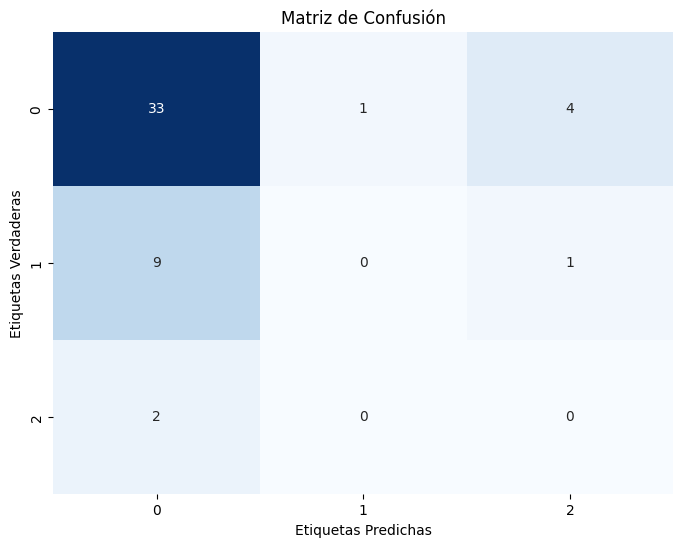

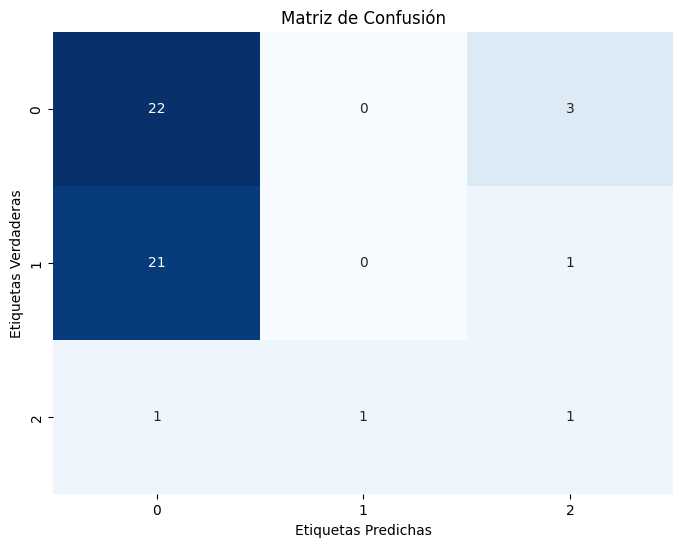

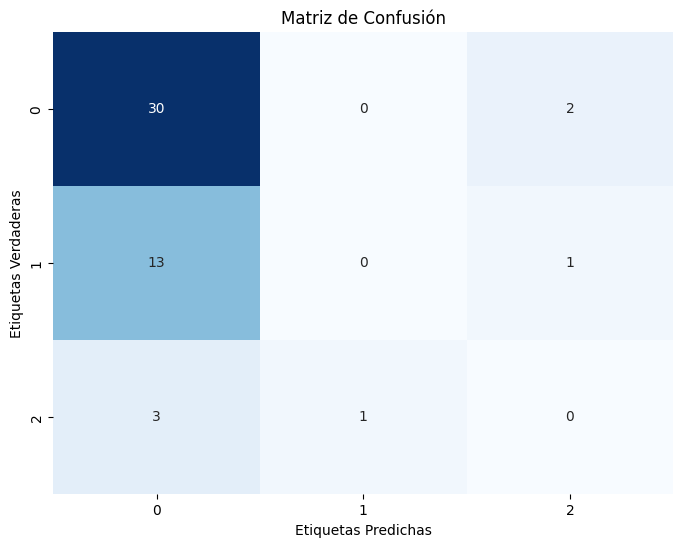

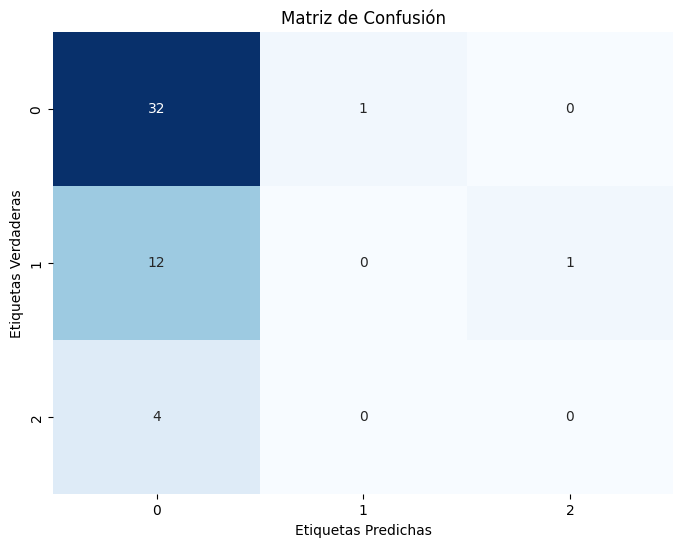

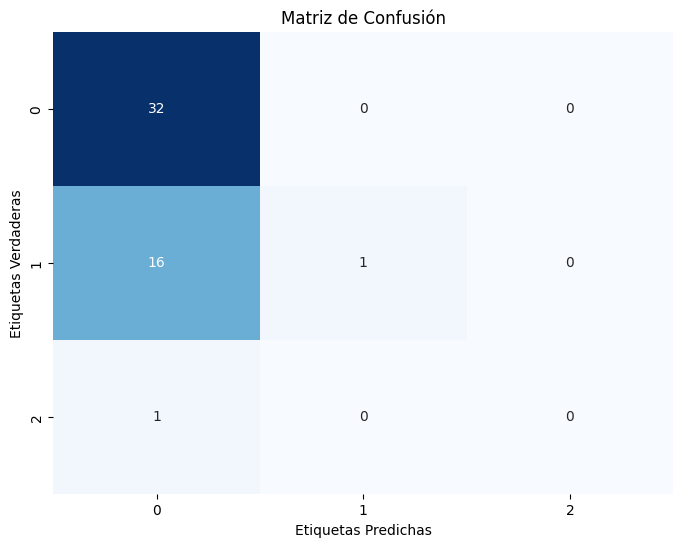

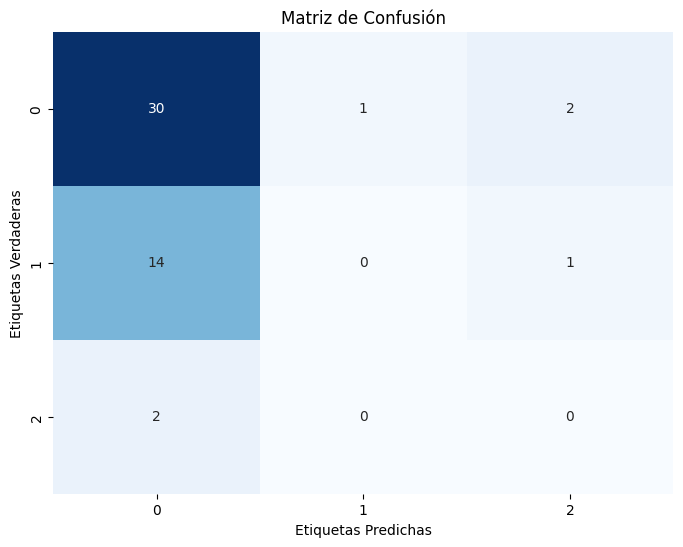

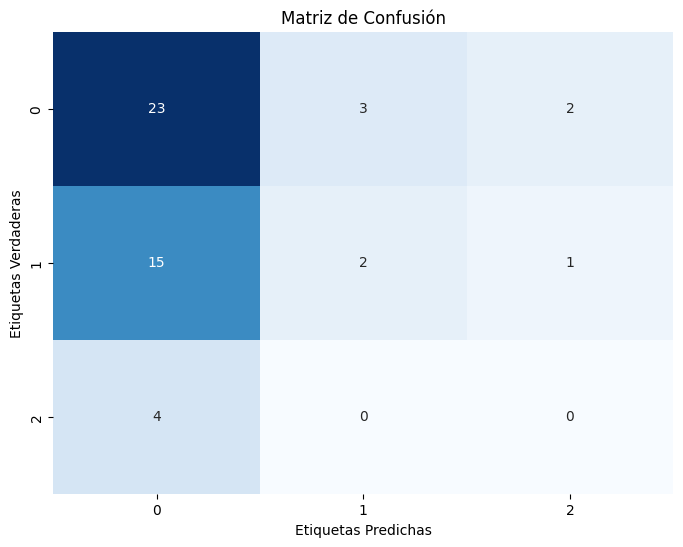

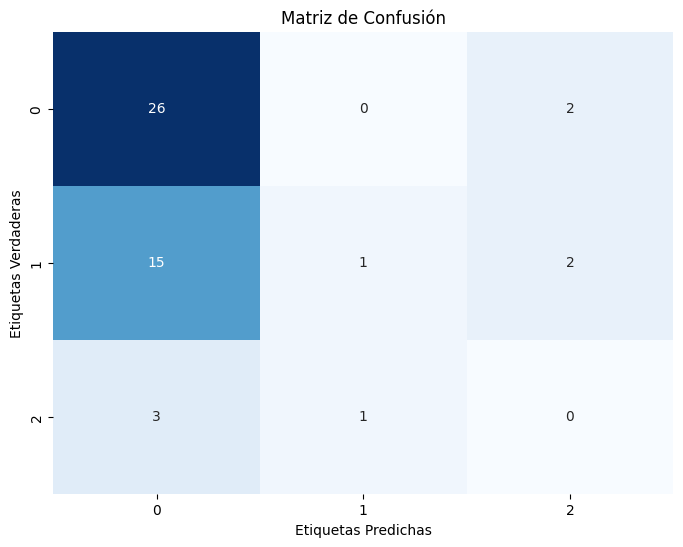

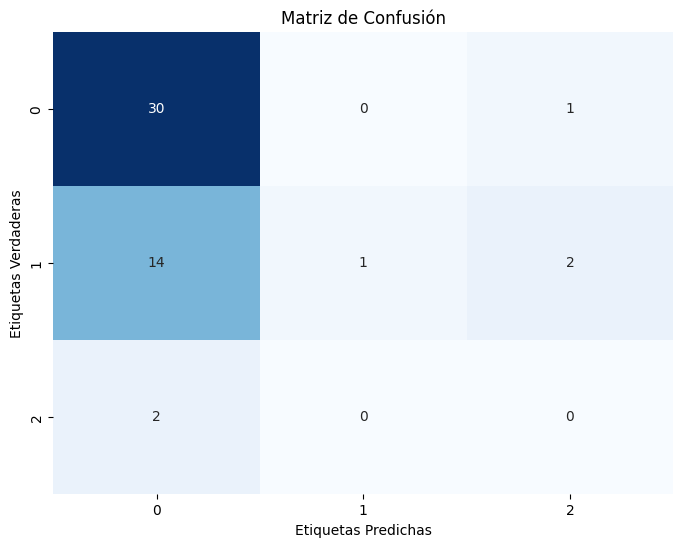

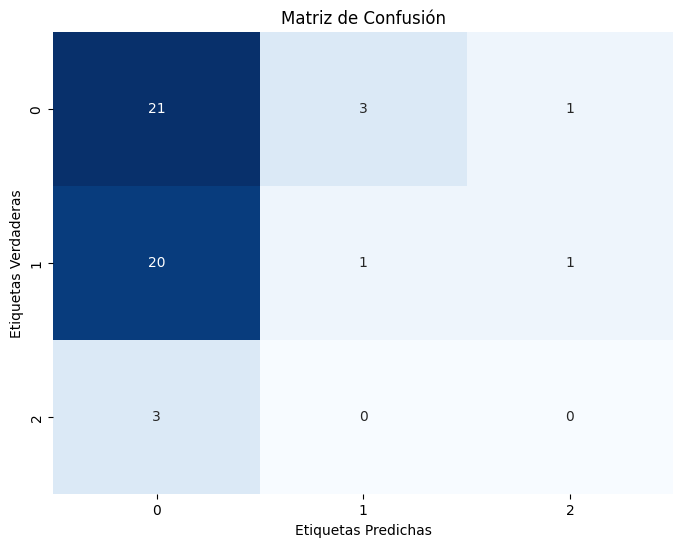

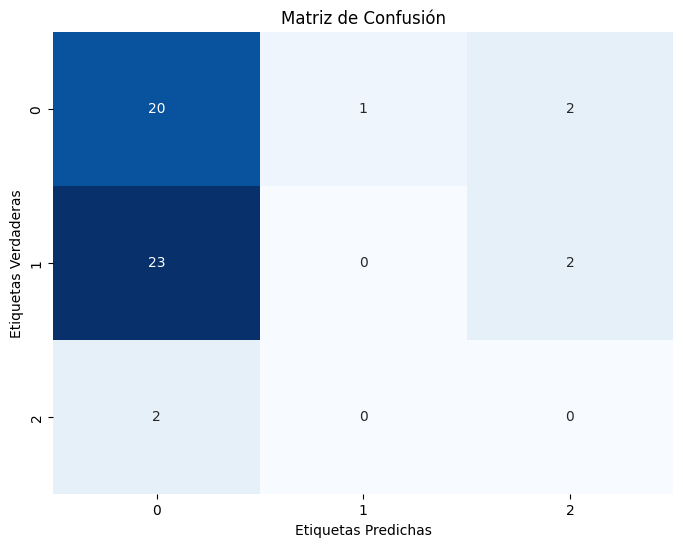

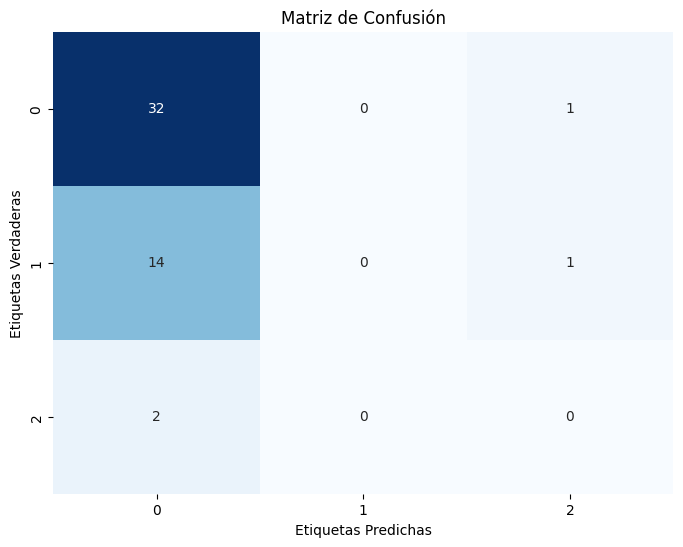

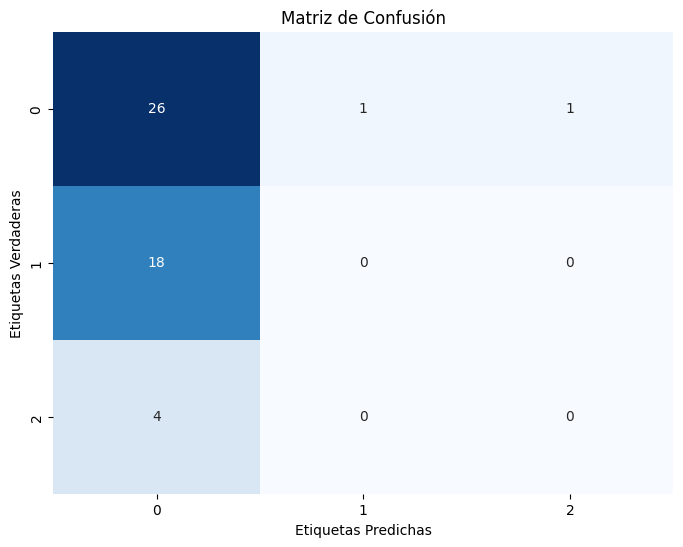

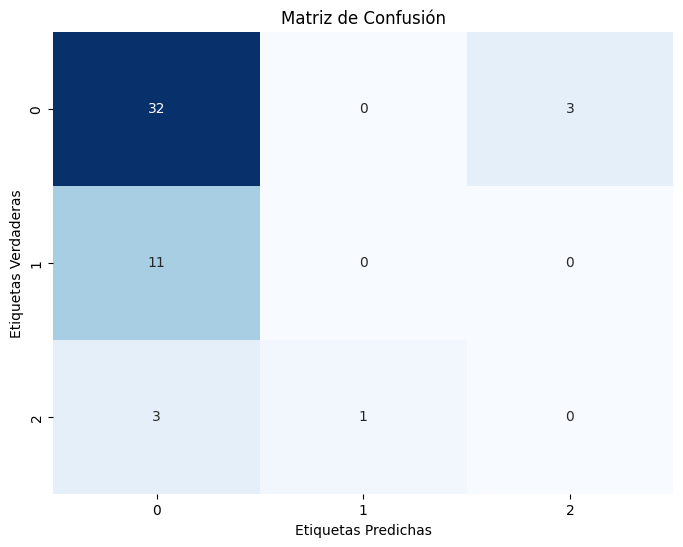

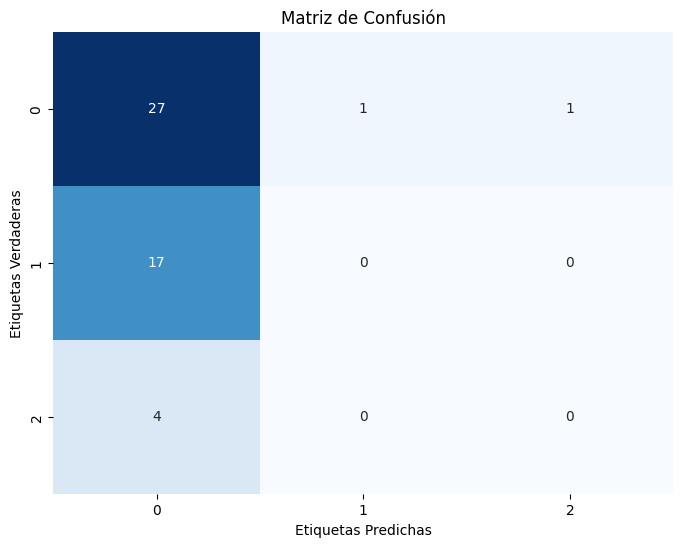

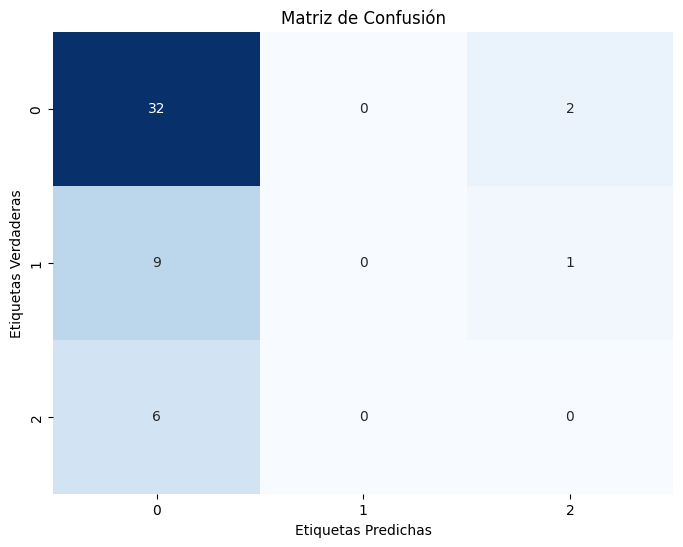

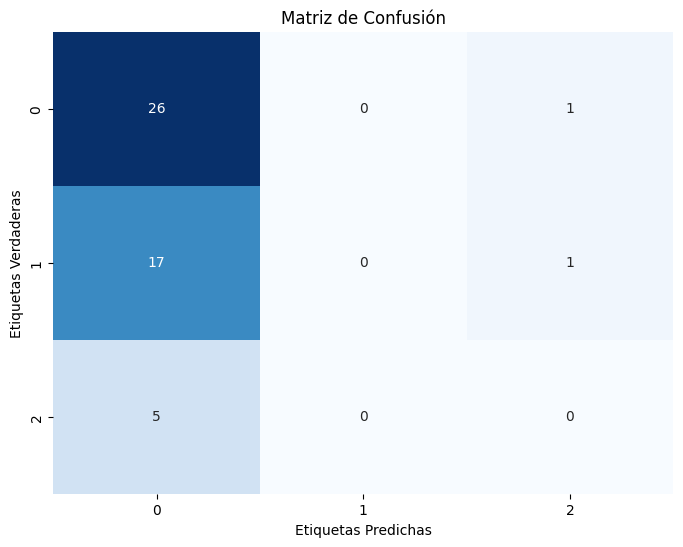

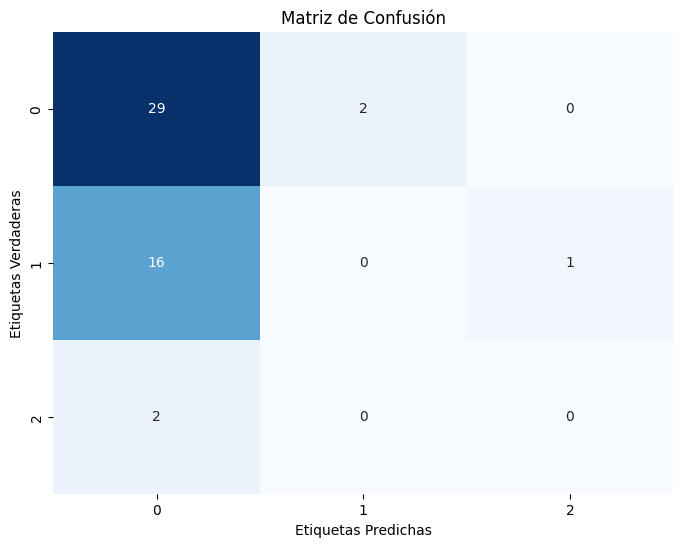

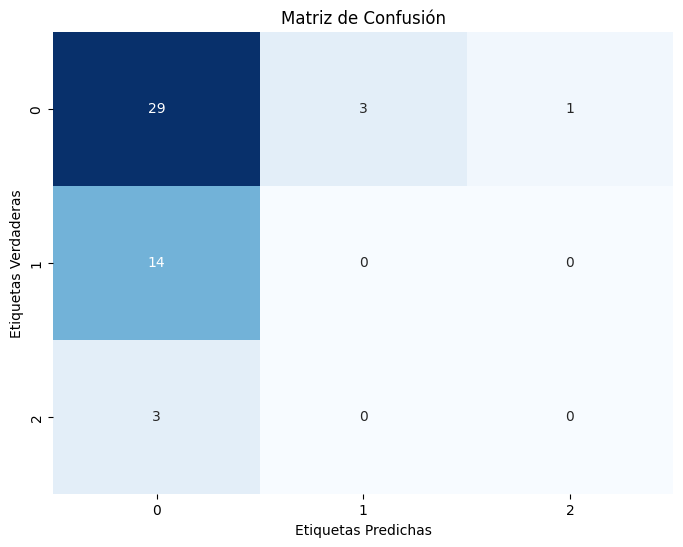

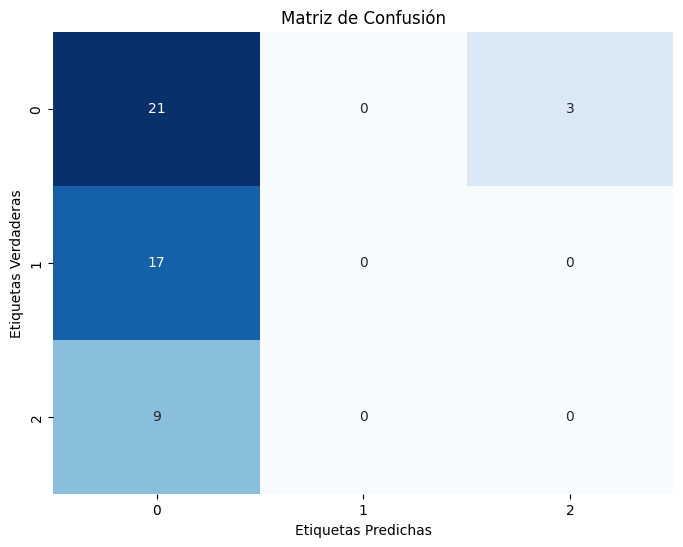

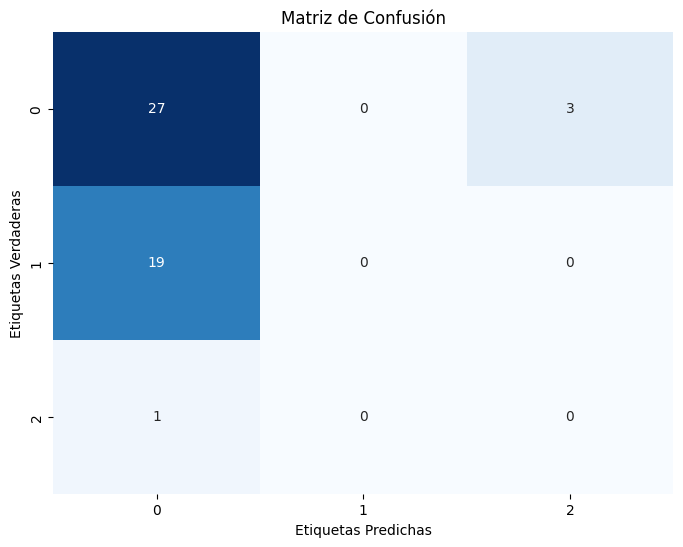

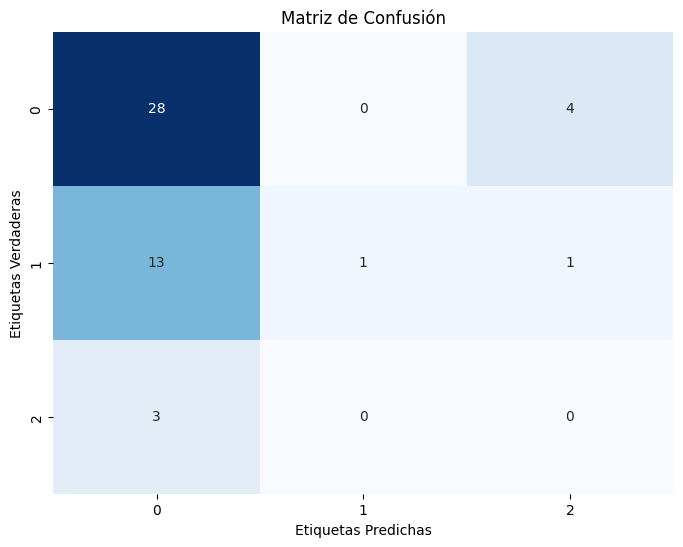

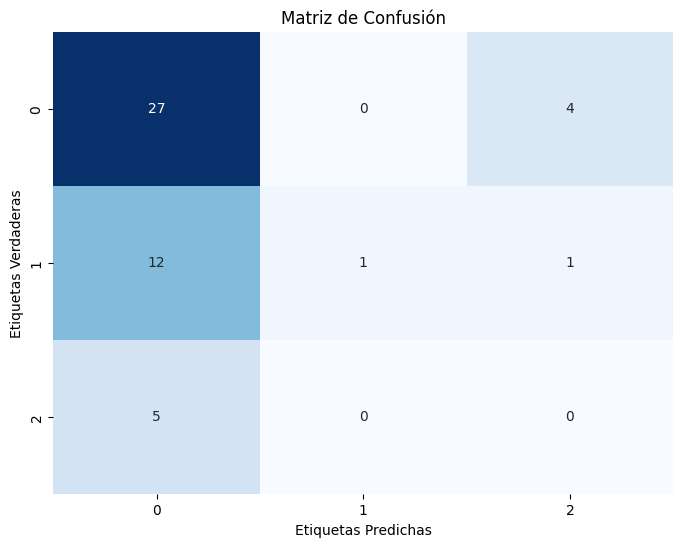

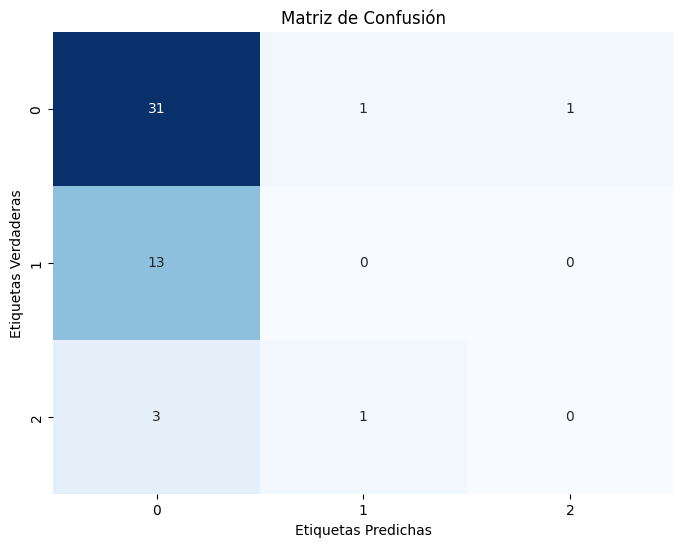

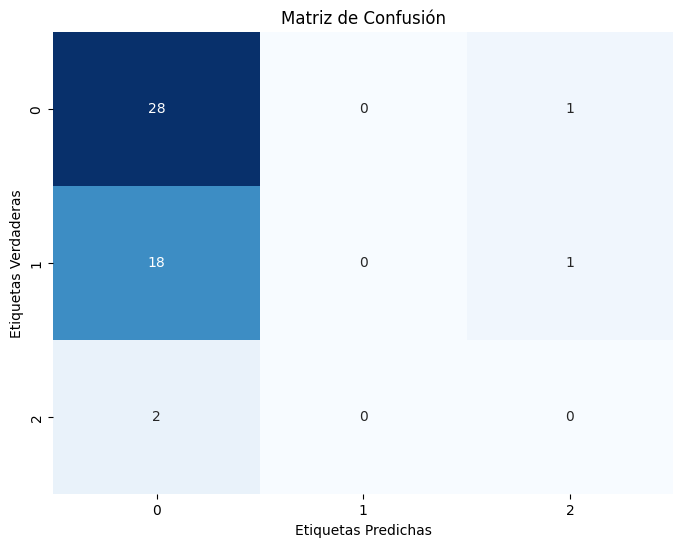

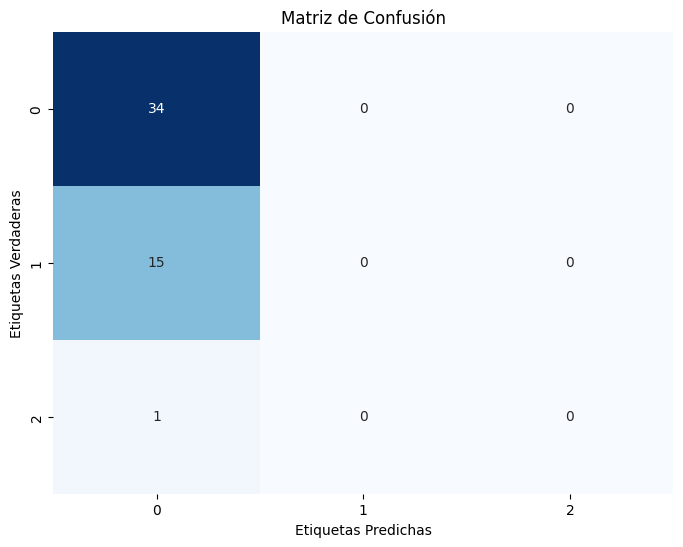

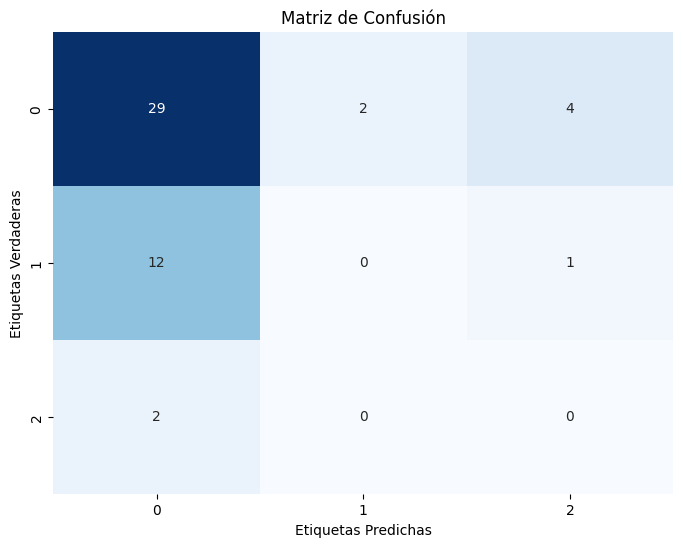

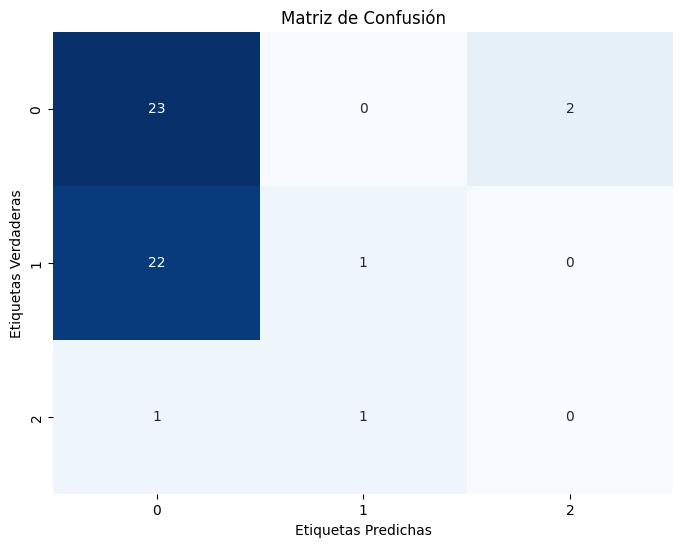

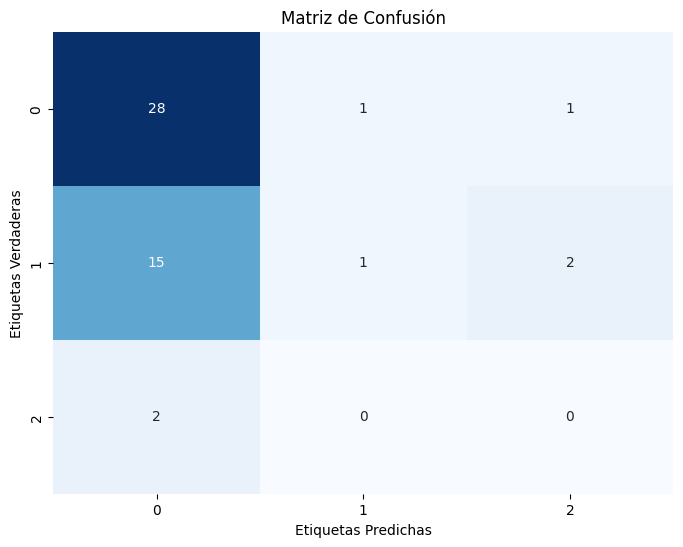

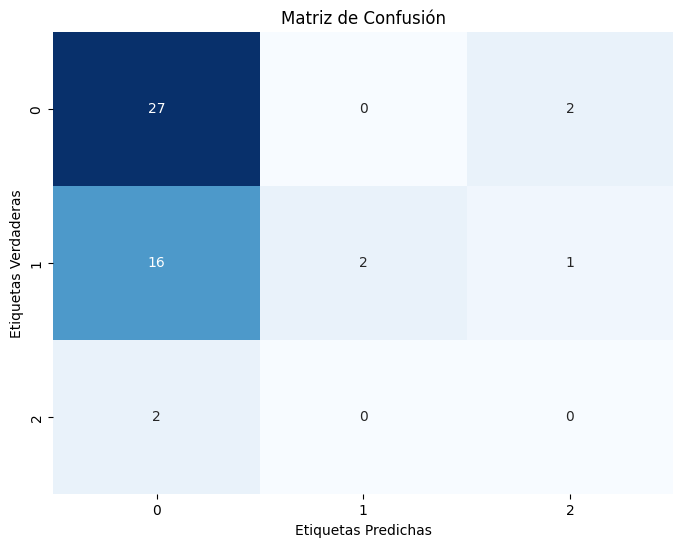

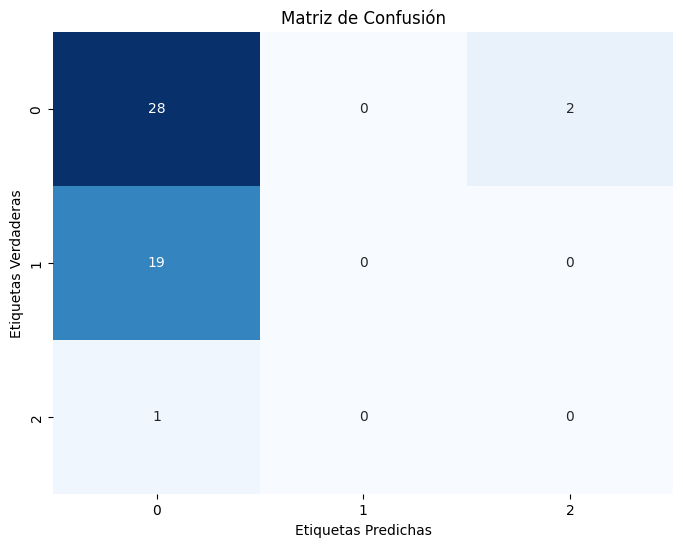

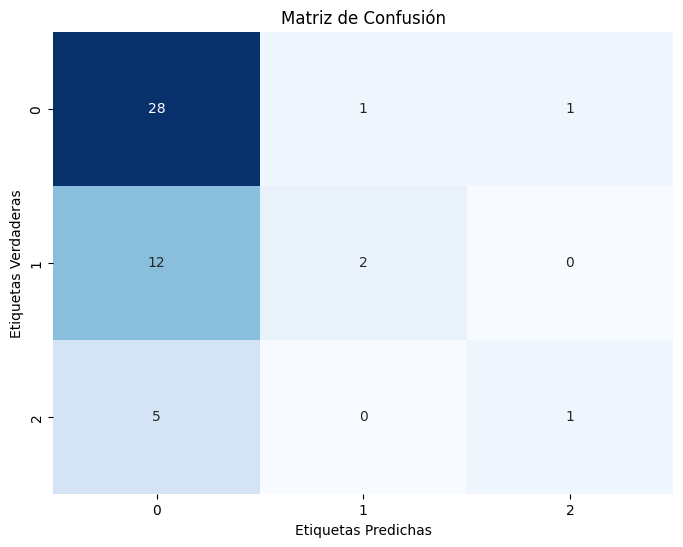

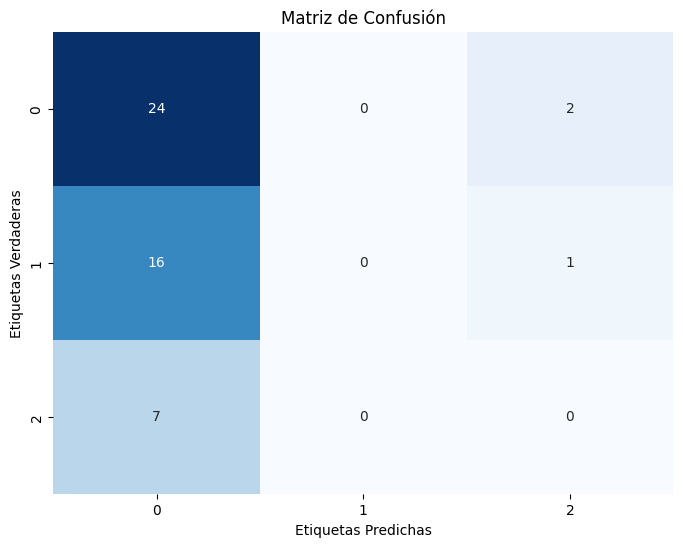

prueba_loss=  4.95 prueba_acc_gen= 0.97 prueba_acc_edad= 0.56 prueba_f1= 0.46


In [22]:
prueba_loss, prueba_acc_gen, prueba_acc_edad , prueba_f1 = eval_epoch(dl_prueba, model, device2)
# tst_loss_vit, tst_acc_vit = eval_epoch(dl_val, model, device2)

# print(f'prueba_acc={prueba_acc_vit:5.2f} tst_acc={tst_acc_vit:5.2f}')
print(f'prueba_loss={prueba_loss:6.2f} prueba_acc_gen={prueba_acc_gen:5.2f} prueba_acc_edad={prueba_acc_edad:5.2f} prueba_f1={prueba_f1:5.2f}')